# Pattern Recognition - Tarea 2 - Automatic Segmentation

## Introduction

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import sklearn
import pandas as pd
import os
from skimage import io
from skimage.color import rgb2gray
import scipy
from scipy.signal import convolve2d

# ML classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

We are firstly going to read all images.

In [3]:
# estagblishing the paths
img_path = "/home/osboxes/Documents/python/recpatr/auto-segmentation/"
img_path = "/u/a/2019/apoupeau/Documentos/recpatr/auto-segmentation"
img_raw_path = os.path.join(img_path, "datos_tarea2/raw.tif")
img_seg_path = os.path.join(img_path, "datos_tarea2/segmentacion_referencia.tif")

# getting raw and ground truth data
raw_data = io.imread(img_raw_path)
seg_data = np.array((1/255) * io.imread(img_seg_path), dtype=int) # class 0 : 255 => to 0 : 1

# get info 55 images of shape 512x512
print(raw_data.shape)
print(seg_data.shape)

print("min-max values raw :", np.min(raw_data), np.max(raw_data))
print("min-max values seg :", np.min(seg_data), np.max(seg_data))

(55, 512, 512)
(55, 512, 512)
min-max values raw : 1 255
min-max values seg : 0 1


Create some tools functions like display an image.

## Convolution 

We want to extract caracteristics from each images. In order to do that we will first create three kernels (filters) and a function that make the convolution. 

http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

In [4]:
# KERNELS
mean_kernel = 1/9 * np.ones(shape=(3,3))

sobelx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])

sobely_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]])

laplacian_kernel = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]])

In [5]:
def testConvolution():
    test_img = io.imread(os.path.join(img_path, "img/building.jpg"))
    # test_img = io.imread(os.path.join(img_path, "img/chair.jpg"))
    # test_img = raw_data[0]
    test_img = rgb2gray(test_img)

    # original img
    plt.figure(figsize=(14,8))
    plt.title("Original")
    plt.imshow(test_img, cmap="gray")
    plt.show()

    # mean kernel
    trans_img = convolve2d(test_img, mean_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Edge Detection - Mean Kernel")
    plt.imshow(trans_img, cmap="gray")
    plt.show()

    # sobelx kernel
    transx_img = convolve2d(test_img, sobelx_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("X Detection - Sobel x Kernel")
    plt.imshow(transx_img, cmap="gray")
    plt.show()

    # sobely kernel
    transy_img = convolve2d(test_img, sobely_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Y Detection - Sobel y Kernel")
    plt.imshow(transy_img, cmap="gray")
    plt.show()

    # gradient magnitud
    grad_mag = np.sqrt(transx_img**2 + transy_img**2)
    plt.figure(figsize=(14,8))
    plt.title("Gradient Magnitude")
    plt.imshow(grad_mag, cmap="gray")
    plt.show()

    # laplacian kernel
    trans_img = convolve2d(test_img, laplacian_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Edge Detection - Laplacian Kernel")
    plt.imshow(trans_img, cmap="gray")
    plt.show()

## Extract features

We have to extract the three features per pixel for each image. The function thus takes as an input an image of shape (512x512) and returns three "modified" images which shape is equal to (512x512).

In [6]:
def extractFeatures(img, flatten=False):
    """
        Compute three features : mean, magnitud and edge detection.
        
        Arguments:
            img (array) : shape (512,512)
            flatten (bool) : if true return a shape (512*512, 3)
        
        Return:
            features (array) : shape (3,512,512) or (512*512, 3) if flatten=True
    """
    # mean kernel
    blurred_img = convolve2d(img, mean_kernel, "same")
    
    # gradient magnitud
    transx_img = convolve2d(img, sobelx_kernel, "same")
    transy_img = convolve2d(img, sobely_kernel, "same")
    grad_mag = np.sqrt(transx_img**2 + transy_img**2)

    # laplacian kernel
    lap_img = convolve2d(img, laplacian_kernel, "same")
    
    # concatenate
    features = np.array([blurred_img, grad_mag, lap_img])
    if flatten:
        flatten_features_img = np.zeros(shape=(3, len(lap_img)**2))
        for i, feature in enumerate(features):
            flatten_features_img[i] = feature.flatten()
        features = flatten_features_img.T
    
    return features

In [7]:
# test
print(extractFeatures(raw_data[0]).shape)
print(extractFeatures(raw_data[0], flatten=True).shape)

(3, 512, 512)
(262144, 3)


In [8]:
def linkImgFeaturesAndClass(img, class_pixels_img):
    """
        Arguments:
            img (array) : raw image (512,512)
            class_pixels_img (array) : values 0 or 1 in it, class for each pixel of the img
        
        Return:
            features_and_class (array) : shape (512*512, 4)
    """
    # extract features
    features_img = extractFeatures(img=img)
    
    # get dataset for the current img
    shp = features_img.shape
    flatten_features_img = np.zeros(shape=(4, shp[-1]**2))
    for i, feature in enumerate(features_img):
        flatten_features_img[i] = feature.flatten()
    
    # concatenate class_pixels_img and features
    flatten_features_img[-1] = class_pixels_img.flatten()
    features_and_class = flatten_features_img.T
    
    return features_and_class

In [9]:
# test ok
linkImgFeaturesAndClass(raw_data[0], seg_data[0]).shape

(262144, 4)

## Construct dataset

In [10]:
def computeclfDataset(X, y, nb_max_img=55):
    """
        X (array) : all raw images
        y (array) : label for all pixel
        nb_max_img (int) : value in [1, 55], default all images
        
        Return:
            dataset (array) : (nb_max_img*512*512, n_features+1 = 4)
    """
    dataset = np.array([0, 0, 0, 0])
    for img, class_pixels_img in zip(X[:nb_max_img], y[:nb_max_img]):
        dataset = np.vstack((dataset, linkImgFeaturesAndClass(img, class_pixels_img)))
    # get rid of the first row
    dataset = dataset[1:, :]
    return dataset

In [55]:
clf_dataset = computeclfDataset(X=raw_data, y=seg_data, nb_max_img=30)

In [56]:
# test
print(clf_dataset.shape)

(7864320, 4)


In [13]:
def equilibrate(dataset, margin=1.25, disp=False):
    """
        Help to solve the "ONLY 1 PREDICTION PROBLEM".
    
        Arguments:
            dataset (array) : shape (n_samples, n_features)
            margin (int) : if 1 => nb_ones = nb_zeros, if 2 => nb_ones = 2*nb_zeros
            
        Return:
            dataset (array) : shape (n < n_samples, n_features)
    """
    nb_zeros = len(dataset[dataset[:, -1] == 0])
    if disp:
        print("Number of 0 class samples =", nb_zeros)
        print("Number of 1 class samples =", len(dataset) - nb_zeros)
        print("Equilibrating...")
    
    # equilibrate dataset in a quick way
    np.random.shuffle(dataset)
    subset_ones = dataset[dataset[:, -1] == 1][:int(nb_zeros*margin), :]
    subset_zeros = dataset[dataset[:, -1] == 0]
    dataset = np.vstack((subset_ones, subset_zeros))
    np.random.shuffle(dataset)
    
    if disp:
        nb_zeros = len(dataset[dataset[:, -1] == 0])
        print("Number of 0 class samples =", nb_zeros)
        print("Number of 1 class samples =", len(dataset) - nb_zeros)
    
    return dataset

In [57]:
equilibrate(clf_dataset, disp=True, margin=1.25).shape

Number of 0 class samples = 1525622
Number of 1 class samples = 6338698
Equilibrating...
Number of 0 class samples = 1525622
Number of 1 class samples = 1907027


(3432649, 4)

In [15]:
def preprocessDataset(clf_dataset):
    """
        IN ORDER TO COUNTER THE "ONLY 1 PREDICTION PROBLEM" make the dataset
        homogenous such that there are as many 1 samples as 0.
        This way, classifiers will learn in a homogenous way.
        
        Argument:
            dataset (array) : shape (n_samples, n_features)
            
        Return:
            train_ (array) : shape (n < n_samples, n_features)
    """
    # 1 - DIVIDE train / test
    pct_train = 0.8
    train_clf_data = clf_dataset[:int(len(clf_dataset)*pct_train), :]
    test_clf_data = clf_dataset[int(len(clf_dataset)*pct_train):, :]
    
    # 2 - EQUILIBRATE and SHUFFLE data the train and test dataset
    # remove all 1 elements until there are as numerous as the number of 0 elements
    train_clf_data = equilibrate(dataset=train_clf_data)
    test_clf_data = equilibrate(dataset=test_clf_data)
    
    return train_clf_data, test_clf_data

In [58]:
train_clf_data, test_clf_data = preprocessDataset(clf_dataset=clf_dataset)

In [59]:
print(train_clf_data.shape)
print(test_clf_data.shape)

(2746129, 4)
(686520, 4)


## Segmentation

Now we are going to classify using the dataset we have.

In [ ]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, n_jobs=64)

clf.fit(train_clf_data[:, :-1], train_clf_data[:, -1])

Accuracy = 0.6669186622385364
Confusion matrix, without normalization
[[134965 170155]
 [ 58512 322888]]


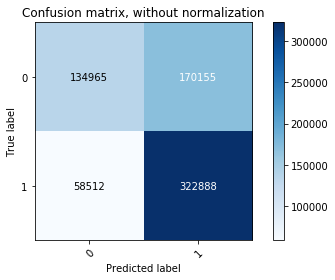

In [65]:
y_pred = clf.predict(test_clf_data[:, :-1])
y_true = test_clf_data[:, -1]

#        [   ] 
#  true  [   ]
#        pred
conf_mat = confusion_matrix(y_pred=y_pred, y_true=y_true)
acc = np.sum(np.diag(conf_mat))/np.sum(conf_mat)
print("Accuracy =", acc)
plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=[0, 1])
plt.show()

In [21]:
# the bad thing is that is always predict 1 because there are much more pixel that 
np.min(clf.predict(extractFeatures(img=raw_data[-5], flatten=True)))

0.0

We need to analyze how good it can predict the class. The idea is to visualize this with a image.

In [22]:
def visuImgClf(img, trained_clf):
    """
        Arguments:
            img (array) : image
            trained_clf (sklearn classifier) : classifier
            
        Return:
            predictions (array) : classified image
    """
    features_img = extractFeatures(img=img, flatten=True)
    
    predictions = trained_clf.predict(features_img)
    
    return predictions

In [28]:
def displayPredAndTrue(img, trained_clf, class_pixels_img):
    """
        Arguments:
            img (array) : image
            trained_clf (sklearn classifier) : classifier
            class_pixels_img (array) : ground truth classification
            
        Dsiplay:
            3 images :
                -image
                -image prediction
                -ground truth
    """
    # get predictions class for all pixel in the image
    predictions = visuImgClf(img=img, trained_clf=trained_clf)
    nb_zeros = len(predictions[predictions == 0])
    print("Number of predicted zeros =", nb_zeros)
    print("Number of predicted ones =", len(predictions) - nb_zeros)

    # reshape into an image and 0 : 1 => 0 : 255
    n = len(class_pixels_img)
    predictions = 255 * np.reshape(predictions, (n, n))
    class_pixels_img *= 255

    # disp images
    plt.imshow(predictions, cmap="gray")
    plt.title("Prediction")
    plt.show()

    plt.imshow(class_pixels_img, cmap="gray")
    plt.title("Ground Truth")
    plt.show()

Image negative index = -6
Number of predicted zeros = 48654
Number of predicted ones = 213490


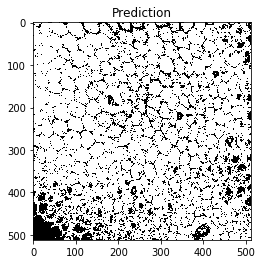

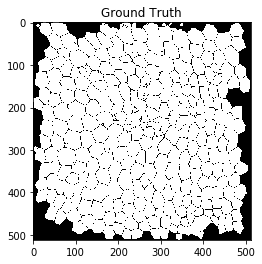

In [68]:
random_visu_idx = -np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print("Image negative index =", random_visu_idx)
displayPredAndTrue(img=raw_data[random_visu_idx], 
                   trained_clf=clf, 
                   class_pixels_img=seg_data[random_visu_idx])

## Best model selection - Cross-Validation & Grid Search

We are going to use cross-validation in order to evaluate different models and for each model the best hyperparameters possible.

In [ ]:
def gridSearchCV(clf_dataset):
    """
        
        Arguments:
            clf_dataset ()
    """